# Projet Simulation Numérique ENSEEIHT 2022-2023
### Groupe: B1
### Nom:Lahmouz
### Prénom: Zakaria
### Commentaire: 

# Informations pratiques

**Modalités pédagogiques** 

Le projet Simulation Numérique vise à vous faire découvrir un algorithme particulier en lien avec d'autres modules d'enseignement de cette année et d'illustrer certaines notions et propriétés à partir de programmes simples que vous devez écrire ou bien compléter. Le langage de programmation proposé est Python. Une connaissance basique de Python et de Numpy est suffisante. 

Cette année, il vous est demandé en premier lieu un travail de compréhension des algorithmes principaux sur la base du C/TD du 10/3/23 et des liens en fin de Notebook. Ensuite est demandé un travail d'implantation informatique simple (partie A) et quelques applications sur des images vous sont proposées (partie B). Ce travail est notamment guidé, des questions de compréhension sur les algorithmes sont posées en Partie C. La partie D vous permet d'implanter un algorithme populaire à titre de comparaison. Le volume de travail demandé est raisonnable.

**Enseignement**

Voici les informations concernant les séances (date, heure):

10/3/23 14.00-16.00 C/TD Groupes B1 et B2 (B306)

14/3/23 14.00-18.00 TP Groupe B1 (C306)

17/3/23 08.00-12.00 TP Groupe B2 (C203)

24/3/23 14.00-16.00 TD Séance de réponse à vos questions (B306)

**Evaluation**

L'évaluation se basera uniquement sur le Notebook que vous devrez rendre. 

**Date limite de rendu**:  19 avril 2023 à midi. 

**Contact**: xavier.vasseur@irit.fr

Merci d'indiquer [PSN] en sujet de votre email pour m'aider à identifier vos requêtes.

**Préambule** L'objectif de ce projet est d'analyser quelques algorithmes de factorisation structurée (déterministe ou aléatoire) de matrices de grande taille. Nous nous intéressons à des algorithmes de factorisation dits "Interpolative Decomposition (ID)" ou "CUR-ID", où l'on cherche à approcher au mieux une matrice en un produit de matrices de rang faible. Les algorithmes seront comparés si possible sous différents angles: temps de calcul, complexité opératoire, précision numérique notamment. Nous envisagerons également l'utilisation d'algorithme dit de factorisation non-négative en fin de projet.

**NB:** Il vous est demandé d'insérer vos commentaires et codes **uniquement** dans ce fichier Notebook. Vous avez toute liberté pour créer des cellules soit de texte soit de code. Vous devez disposer comme données de ce fichier et de quelques images au format .jpg. Le rendu sera uniquement ce fichier Notebook dans lequel vous devez insérer l'ensemble de vos résultats. 

Ce projet est en lien notamment avec les cours suivants:

   * Calcul scientifique
   * Algèbre linéaire pour le data mining
   * Optimisation II

In [1]:
#
# Chargement des bibliotheques pour la visualisation, l'algebre lineaire et l'analyse du temps de calcul 
#
import matplotlib.pyplot as plt
import numpy as np
from   scipy import fftpack
from   scipy.linalg import qr, norm, solve_triangular, svd
from   PIL import Image
import time

### Introduction.

L'approximation de rang faible que nous utiliserons dans ce projet se base sur une connaissance du rang exact ou du rang approché de la matrice étudiée. A titre informatif, la méthode suivante vous permet d'obtenir une majoration du rang d'une matrice rectangulaire $A$ telle que $ \|A - Q Q^T A \|_F \le \epsilon \|A \|_F$, $\epsilon$ désignant une tolérance choisie par l'utilisateur. Cette méthode sera donc utile par la suite dans vos expérimentations numériques, aucune modification n'est a priori requise. 


In [2]:
def adaptive_rank_determination(A,epsilon,blocking=16,iteration_max=10):
    """
    Adaptive rank determination based on randomization
    We look for an orthogonal matrix Q such that 
    $\|A - Q Q^T A \|_F \le \epsilon \|A \|_F$
    where $\|.\|_F$ denotes the Frobenius norm.
    
    Reference: Adapted from Section 12 of P.G. Martinsson, "Randomized methods for matrix computations", 2019, 
    ArXiv 1607.01649 [https://arxiv.org/pdf/1607.01649.pdfs]. The original algorithm corresponds to 
    Figure 12. 
    
    Input: 
    A:        matrix to be analysed [array type] (of shape (m,n))
    epsilon:  relative threshold related to the accuracy of the projection (in the Frobenius norm) (0<= epsilon <= 1)
    blocking: blocking parameter to be used in the implementation (for efficiency reasons) [int]
    
    Output:
    Q: matrix with orthonormal columns such that $ \|A - Q Q^T A \|_F \le \epsilon \|A \|_F$
    erank: estimated rank (upper bound of epsilon-rank(A)), erank is here a multiple of min(blocking,n). 
    ratio: current ratio of $\|A - Q Q^T A \|_F4$ divided by $\|A \|_F$
    iteration: nombre d'itérations réalisé au sein de l'algorithme
    """ 
    
    m, n          = A.shape[:]
    # The blocking parameter should be less than the number of columns
    b             = min(blocking,n)
    iteration     = 0
    # Update the maximal number of iterations according to b
    iteration_max = max(np.ceil(n/b),iteration_max) 
    norm_A_Fro = norm(A,'fro')
    
    while norm(A,'fro') > epsilon*norm_A_Fro and iteration < iteration_max:
        # Create R the random block based on Gaussian variables
        R      = np.random.randn(n,b)
        # Matrix-matrix product Y = AR 
        Y      = A@R
        # QR decomposition of Y
        QY, RY = qr(Y,mode='economic')
        # Compute the projection 
        BY     = QY.T@A
        # Concatenate the information related to Q and B
        if iteration == 0:
            Q  = QY
            B  = BY
        else:
            Q  = np.concatenate((Q, QY),axis=1)
            B  = np.concatenate((B, BY),axis=0)
        # Update the iteration count
        iteration += 1
        # Update of A
        A = A - QY@BY
        # Upper bound of epsilon-rank
        erank = Q.shape[1]
        
    return Q, Q.shape[1], norm(A,'fro')/norm_A_Fro, iteration

## Partie A.1

Proposer une implantation des différents algorithmes de décomposition vus en cours. Pour vous aider, une définition des fonctions et leurs squelettes sont proposés. Vous avez toute liberté pour les modifier. Ces algorithmes seront utilisés dans la partie de validation (Partie B) et applicative du Notebook (Partie C). Vous pourrez vous appuyer sur les <a href="https://arxiv.org/pdf/1607.01649.pdf">chapitres 10 et 11 des notes de cours de P.G. Martinsson</a>:


In [3]:
def column_ID(A,k):
    """
    Compute a column interpolative decomposition such that 
    A \approx A[:,J] Z
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    J  is the set of column indices [array, any type] (of shape k)
    Z  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    
    m, n = A.shape[:]
    Z    = np.zeros(shape=(k,n))
    
    #
    # TO DO
    #
    # Perform the economic decomposition of A with column pivoting 
    
    QA,RA,P=qr(A,mode='economic',pivoting=True)
    
    
    # Deduce the T=R11^{-1}R12 block 
    # T est R11(-1)*R12
    T=solve_triangular(RA[:k,:k],RA[:k,k:n])
    
    
    
    # Deduce J and Z 
    J=P[:k]
    # concatenation de Ik et T
    Z[:,P]=np.concatenate((np.eye(k),T),axis=1)
    
    
    #
    # END TO DO
    #
    
    return J,Z


def row_ID(A,k):
    """
    Compute a row interpolative decomposition such that 
    A \approx X A[I,:] 
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    I  is the set of row indices [array, any type] (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    
    m, n = A.shape[:]
    X    = np.zeros(shape=(m,k))
    
    #
    # TO DO
    #
    
    # Perform the economic decomposition of A^T with column pivoting 
    
    Q,R,P=qr(np.transpose(A),mode='economic',pivoting=True)
    
    

    # Deduce the corresponding T block 
    
    T=solve_triangular(R[:k,:k],R[:k,k:m])
    
    # Deduce I and X 
    
    I=P[:k]
    X[P,:]=np.concatenate((np.eye(k),T),axis=1).T
    #
    # END TO DO
    #
    
    return I,X

def double_sided_ID(A,k):
    """
    Compute a double sided interpolative decomposition such that 
    A \approx X A(I,J) Z 
    
    Input: 
    A matrix to be analysed [array type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    I  is the set of row indices [array] (of shape k)
    J  is the set of column indices [array] (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    Z  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    #
    # TO DO
    #
    
    # Apply the column ID to A
    
    J,Z=column_ID(A,k)
   
    # Apply the row ID to A[:,J]
    I,X=row_ID(A[:,J],k)
    
    #
    # END TO DO
    #
    
    return I,J,X,Z

def extract_subblock(A,I,J):
    """
    Given a set of row and column indices, extract the submatrix 
    B = A[I,J]
    with I the set of row indices and J the set of column indices.
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    I  is the set of row indices  (of shape k)
    J  is the set of column indices  (of shape k)
    
    Output:
    Matrix A[I,J] [array] (of shape (k,k))
    """
    B = np.zeros(shape=(len(I),len(J)))
    row_index = 0
    
    for i in I:
        col_index = 0
        for j in J:
            B[row_index,col_index] = A[i,j]
            col_index = col_index + 1
            
        row_index = row_index + 1
    
    return B

def cur(A,k):
    """
    Deterministic version of the CUR algorithm based on the 
    double sided ID decomposition. 
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]  
    
    Output:
    C  is the corresponding matrix (of shape (m,k))
    U  is the corresponding matrix (of shape (k,k))
    R  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 11.2 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    #
    # TO DO
    #
    
    # Apply the double sided interpolation algorithm 
    I,J,X,Z=double_sided_ID(A,k)
    
    
    # Deduce the C and R matrices of the CUR formulation 
    # c=J
    C=A[:,J]
    R=A[I,:]
    
    # Solve U R = Z in a least-squares sense
    U=np.dot(Z,np.linalg.pinv(R))
    
    #
    # END TO DO
    #
    return I,J,C,U,R

## Partie A.2 

Proposer une implantation des différents algorithmes aléatoires de décomposition vus en cours. Pour vous aider, une définition des fonctions et leurs squelettes sont proposés. Vous avez toute liberté pour les modifier. Ces algorithmes seront utilisés dans la partie de validation (Partie B) et applicative du Notebook (Partie D). Vous pourrez vous appuyer sur les <a href="https://arxiv.org/pdf/1607.01649.pdf">chapitres 10 et 11 des notes de cours de P.G. Martinsson</a>:


In [5]:
def randomized_row_ID(A,k,p=10,q=2):
    """
    Randomized version of the row ID to decompose matrix A into
    A \approx X A(I,:) 
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    k: estimated rank of matrix A [int]
    p: oversampling parameter (p=10 by default)
    q: number of power iterations (q=2 by default)
    
    Output:
    I  is the set of row indices  (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    
    Reference: Section 10.4 and Figure 8 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    
    """
    m, n = A.shape[:]
    X    = np.zeros(shape=(m,k)) 
    
    # Use the randomized variant to construct Y an approximation of A
    G    = np.random.randn(n,k+p)
    Y    = A@G
   
    #
    # TO DO
    #
    for j in range(1,q+1):
        Y=A@np.transpose(A)@Y
    
    # Apply the row ID algorithm to Y
    I,X=row_ID(Y,k)
    
    
    #
    # END TO DO
    #
    
    return I,X

   
def randomized_cur(A,k,p=10,q=2):
    """
    Randomized version of the CUR algorithm     
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    p: oversampling parameter (p=10 by default)
    q: number of power iterations (q=2 by default)  
    
    Output:
    C  is the corresponding matrix (of shape (m,k))
    U  is the corresponding matrix (of shape (k,k))
    R  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 11.2 and Figure 10 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """    
    m, n = A.shape[:]
    
    # Randomized version starts here
    # Use the randomized variant to construct Y an approximation of A
     
    G    = np.random.randn(k+p,m)
    Y    = G@A
    
    #
    # TO DO
    #
    for j in range(1,q+1):
        Y=Y@(A.T)@A
        
    # Apply the column ID algorithm to Y 
    
    J,Z=column_ID(Y,k)
    
    # Apply the row ID algorithm to A[:,J]
    I,X=row_ID(A[:,J],k)
    
        
    # Deduce the CUR matrices (C, R and then U)
    C=A[:,J]
    R=A[I,:]
    U=Z@np.linalg.pinv(R)
    
    #
    # END TO DO
    #
    return I,J,C,U,R

## Partie B

Nous cherchons à mettre en oeuvre les algorithmes précédents sur une application liée à la reconstruction d'images.
La cellule suivante vous montre comment charger une image et en déduire la matrice associée. Appliquer alors les algorithmes de 
factorisation vus en Partie A et visualiser les images obtenues en fonction du rang estimé.  

### Sydney

(396, 563)


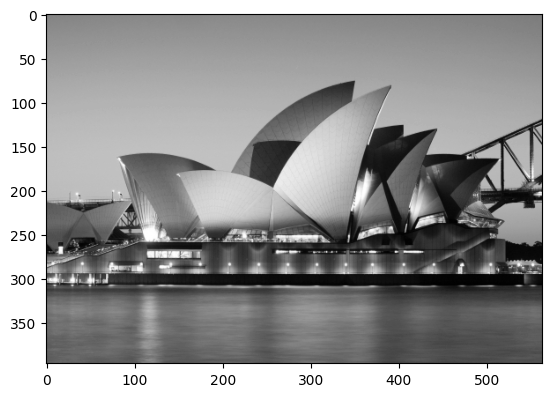

In [6]:
#
# Lecture de l'image 
#
#
imgc = Image.open("Sydney_Opera_House.jpg")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M        = (1./255)*np.array(img_gray)
M_Sydney = M[:]
#
# Affichage de la taille de l'image et de l'image en gris si besoin
#
print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated epsilon-rank 0.0404205322265625
Estimated upper bound of the epsilon-rank:  96  for relative threshold:  0.05
Frobenius norm ratio:  0.04223582118648623  reached in  6 iterations
Time spent in the CUR algorithm 0.14374351501464844
Time spent in the randomized CUR algorithm 0.08286833763122559
Time spent in the double sided ID algorithm 0.09378767013549805


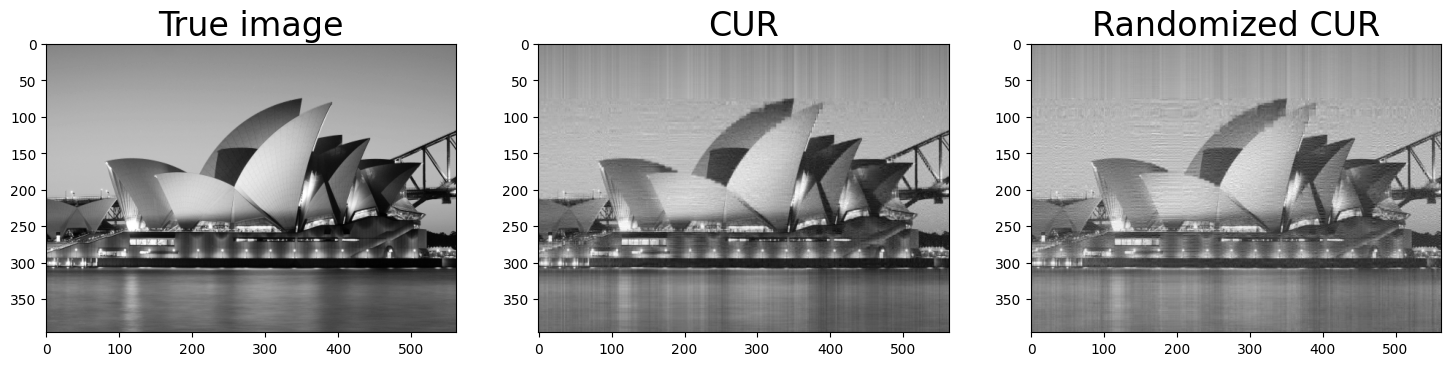

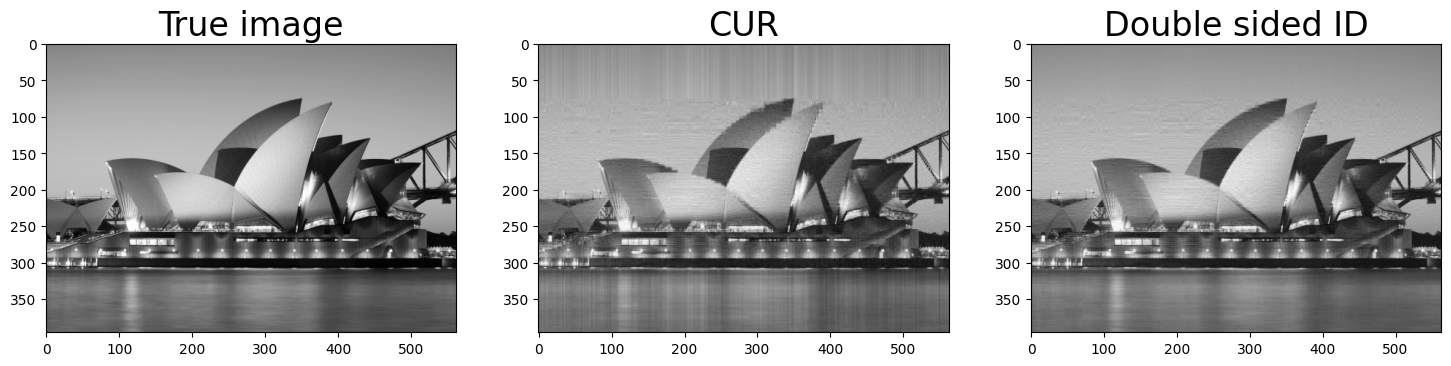

In [7]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
epsilon  = 5.e-2
blocking = 16
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
erank_Sydney = erank
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I, J, C, U, R  = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
#
# Double sided ID
#
t_start        = time.time()
I,J,X,Z        = double_sided_ID(M,erank)
JID_S          = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID_S,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

### Tokyo

(1008, 1212)


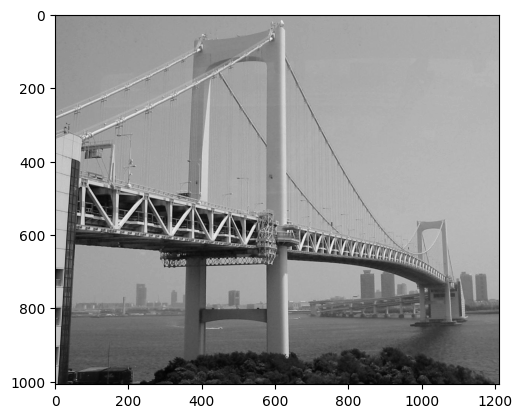

In [8]:
#
# Lecture de l'image 
#
#
#imgc = Image.open("Sydney_Opera_House.jpg")
imgc = Image.open("Tokyo_Rainbow_Bridge.jpg")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M        = (1./255)*np.array(img_gray)
M_Tokyo  = M[:]
#
# Affichage de la taille de l'image et de l'image en gris si besoin
#
print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated epsilon-rank 0.37502479553222656
Estimated upper bound of the epsilon-rank:  160  for relative threshold:  0.05
Frobenius norm ratio:  0.04723203047637387  reached in  10 iterations
Time spent in the CUR algorithm 0.6617522239685059
Time spent in the randomized CUR algorithm 0.23041319847106934
Time spent in the double sided ID algorithm 0.6016943454742432


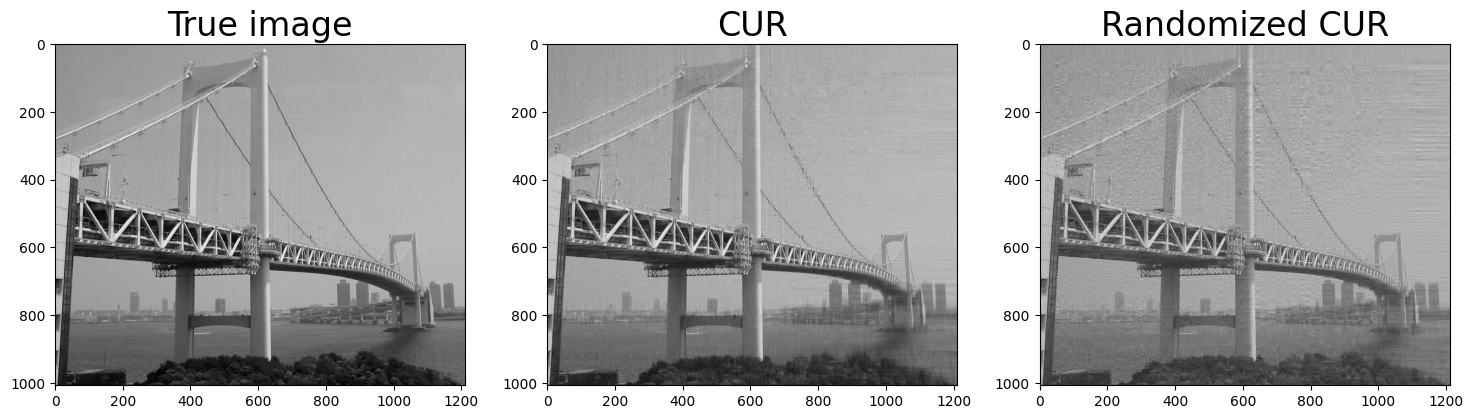

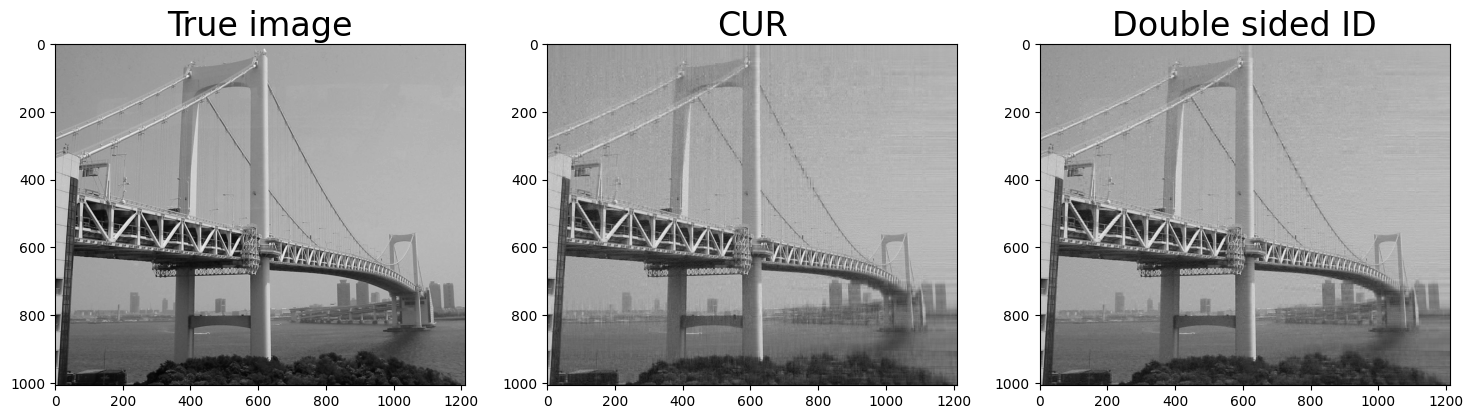

In [9]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
epsilon  = 5.e-2
blocking = 16
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
erank_Tokyo = erank
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I, J, C, U, R  = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
#
# Double sided ID
#
t_start        = time.time()
I,J,X,Z        = double_sided_ID(M,erank)
JID_T          = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID_T,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

### Hamburg

(524, 932)


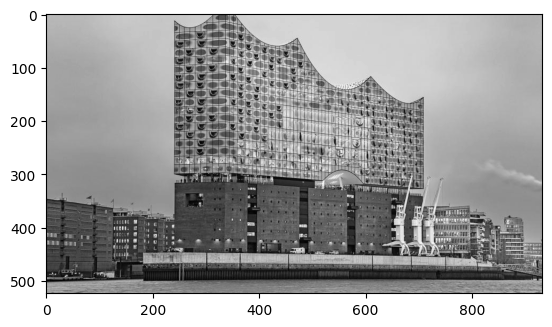

In [10]:
#
# Lecture de l'image [couleur] 
#
#
imgc = Image.open("Hamburg_Elbphilarmonie.jpg")
#
# Conversion de l'image RGB en mode gris et normalisation
#
img      = np.array(imgc)
R        = img[:, :, 0]
G        = img[:, :, 1]
B        = img[:, :, 2]
img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
M         = (1./255)*np.array(img_gray)
M_Hamburg = M[:]

print(np.shape(M))
plt.imshow(M,'gray')
#
# Constantes utiles par la suite
#
m     = np.shape(M)[0] # nombre de lignes de la matrice M
n     = np.shape(M)[1] # nombre de colonnes de la matrice M

Time spent in the determination of the approximated epsilon-rank 0.18021035194396973
Estimated upper bound of the epsilon-rank:  272  for relative threshold:  0.05
Frobenius norm ratio:  0.04747960299592237  reached in  17 iterations
Time spent in the CUR algorithm 0.33591723442077637
(272, 932)
Time spent in the randomized CUR algorithm 0.2677271366119385
(272, 932)
Time spent in the double sided ID algorithm 0.21916699409484863
(272, 932)


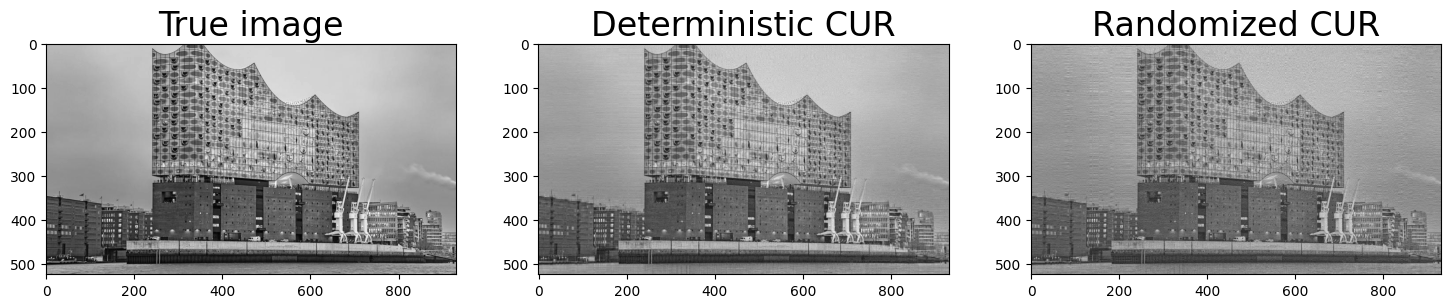

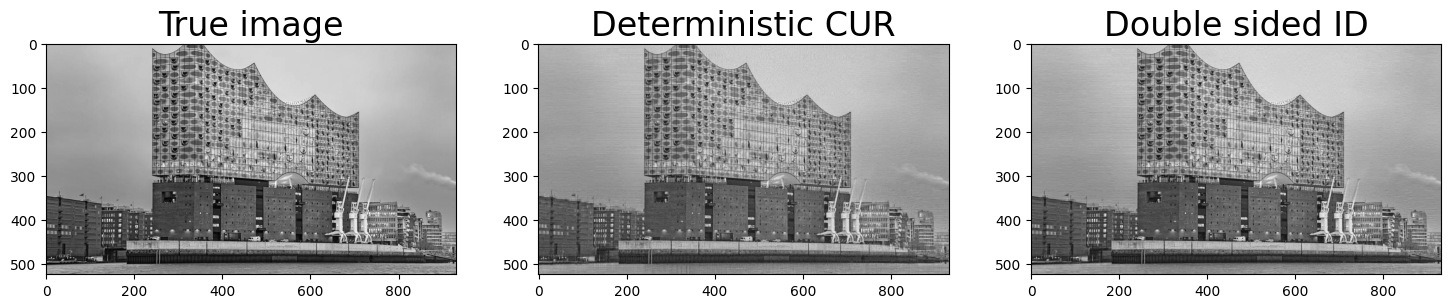

In [11]:
#
# Application of the ID/CUR algorithms to M with erank as target rank
#
t_start  = time.time()
Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
erank_Hamburg = erank
#
# CUR algorithm
#
t_start        = time.time()
I,J,C, U, R    = cur(M,erank)
JCUR_D         = C@U@R
print("Time spent in the CUR algorithm",time.time()-t_start)
print(np.shape(R))
#
# Randomized CUR algorithm
#
p = 5
q = 1
t_start        = time.time()
I,J,C, U, R    = randomized_cur(M,erank,p,q)
JCUR_R         = C@U@R
print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
print(np.shape(R))
#
# Double sided ID
#
t_start  = time.time()
I,J,X,Z  = double_sided_ID(M,erank)
JID_H    = X @ extract_subblock(M,I,J) @ Z
print("Time spent in the double sided ID algorithm",time.time()-t_start)
print(np.shape(Z))
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('Deterministic CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JCUR_R,'gray')
plt.title('Randomized CUR',fontsize=24)
plt.show()

plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(JCUR_D,'gray')
plt.title('Deterministic CUR',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID_H,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

**Question:**
* B.1 Prenez trois valeurs pour $\epsilon$ (par exemple $\epsilon=0.5$, $\epsilon=0.1$ et $\epsilon=0.05$) et analysez la qualité de l'approximation pour les images considérées. Qu'observez-vous ? 

**Réponse**:
On remarque que plus $\epsilon$ est petite plus la qualité de l'approximation de l'image est très bonne.En effet $\epsilon$ est grande siginife une grande marge d'erreur et donc la matrice approximative contient des erreurs significatifs,ainsi des images de mauvaise qualité. Par contre si $\epsilon$ est petite alors la marge d'erreur est  petite mais la complexité de l'algorithme est augmentée.


**Question:**
* B.2 Observez-vous des différences de qualité de reconstruction entre les algorithmes pour une précision identique ?

Avec une précision identique,le double Sided Id garantit la meilleure qualité de reconstruction.
**Réponse**:


## Partie C.

En vous basant notamment sur les notes de cours, le chapitre 11 de <a href="https://arxiv.org/pdf/1607.01649.pdf">Martinsson (2019)</a>, la section 13 de <a href="https://arxiv.org/pdf/2002.01387.pdf">Martinsson et Tropp (2020)</a>,  répondre aux deux questions suivantes:

* C.1 Donner les avantages et inconvénients éventuels de la décomposition déterministe CUR-ID. 

**Réponse**:
* Les avantages de la décomposition déterministe CUR-ID :
    a- la decomposition est rapide car ,pour determiner le rang, elle utilise les methodes de selection en se basant sur les valeurs singulières.$\newline$
    b- Elle conserve la structure de la matrice d'origine.$\newline$
    c- La decomposition donne une approximation de rang faible avec une erreur relative optimale $\newline$
* Inconvenients:
    a- l'algorithme est couteux en memoire puisque il est necessaire de stocker les matrices de selection des lignes et colonnes $\newline$
    b- l'algorithme n'est pas optimal pour une structure matricielle particulière ,par exemple "sparse", $\newline$
En effet on ne tient pas compte de la structure de la matrice lors de la selection des lignes et colonnes;
* C.2 Expliquer comment paralléliser l'algorithme aléatoire CUR-ID.  

**Réponse**:
    D'abord, on doit diviser le nombre de colonnes de la matrice en nombres de coeurs,ensuite il faut distribuer les blocs entre les différents processeurs.Après chaque processeur va appliquer la première étape de l'algorithme sur un bloc précis et obtenir une matrice de projection partielle.Ainsi,on rassemble les différentes matrices en une matrice de projection notée P et on applique la SVD sur P pour récupérer U et V.Puis chaque processeur va calculer la projection du bloc des colonnes associés sur U et R afin de récuperer les indices de lignes globaux.


## Partie D.

Appliquer l'algorithme de factorisation non-négative de <a href="https://proceedings.neurips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf">Lee et Cheung</a> (Théoreme 1) pour obtenir une approximation d'une image donnée en norme de Frobenius. Une attention sera donnée à l'implantation proposée et au temps de restitution obtenu.  Vous pourrez à cet effet utiliser les fonctions multiply et divide de NumPy.

In [19]:
def nmf(M,erank,epsilon,iteration_max):
    """
    Non-negative matrix factorization for matrix M.
    Input: 
    M:             matrix to be analysed [array type] (of shape (m,n))
    erank:         estimated rank (upper bound of epsilon-rank(M))
    epsilon:       relative threshold related to the accuracy of the projection (in the Frobenius norm) (0<= epsilon <= 1)
    iteration_max: maximal number of iterations [int]
    
    Output:
    X,Y: matrices with positive entries such that $ \|M - X Y \|_F \le \epsilon \|M \|_F$
    iteration: effective number of iterations
    """
    m     = np.shape(M)[0] # nombre de lignes de la matrice M
    n     = np.shape(M)[1] # nombre de colonnes de la matrice M
    
    # Specify two possible first iterates for X and Y
    X = np.random.rand(m,erank) 
    Y = np.random.rand(erank,n)

    # Set variables
    norm_A_Fro    = norm(M,'fro')
    iteration     = 0
    
    # Algorithm 
    while norm(M-X@Y,'fro') > epsilon*norm_A_Fro and iteration < iteration_max:
        #
        # TO DO
        #
        Y1=np.divide(np.transpose(X)@M,np.transpose(X)@X@Y)
        Y=np.multiply(Y,Y1)
        X1=np.divide(M@np.transpose(Y),X@Y@np.transpose(Y))
        X=np.multiply(X,X1)

        
        # END TO DO
        #
        if iteration%25 == 0:
            print(iteration,norm(M-X@Y,'fro')/norm_A_Fro)
        iteration=iteration+1

    return X,Y,iteration

0 0.24220486845711256
25 0.22556564457218498
50 0.1757959744339356
75 0.1453347256840757
100 0.1251811839456971
125 0.11184678868410727
150 0.10250386298991186
175 0.09559747120011138
200 0.09028819863238804
225 0.08607683601320407
250 0.08265129932791664
275 0.07980763902893108
300 0.07740661390264382
325 0.0753497930963549
350 0.07356552536251093
375 0.0720001400780295
400 0.0706133419842205
425 0.06937444058684615
450 0.06825963317827013
475 0.06725010772524188
500 0.066331039694116
525 0.06549073288048962
550 0.06471927109979678
575 0.0640081835784605
600 0.06335035068201657
625 0.0627398011334288
650 0.06217140821656329
675 0.06164101151810903
700 0.0611451596458951
725 0.06068068589971302
750 0.060244609889959694
775 0.05983432294810711
800 0.05944755046942846
825 0.05908229026145942
850 0.0587367611490635
875 0.05840937501239561
900 0.05809873158577877
925 0.05780356529580875
950 0.057522691640795945
975 0.05725501220356973
1000 0.056999520411906465
1025 0.056755313877988454
105

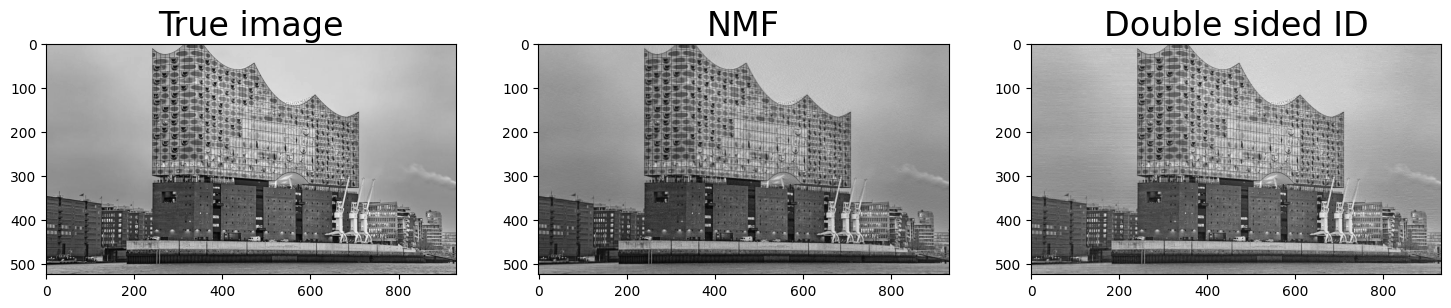

In [20]:
#
# Specify one of the target images here
#
erank = erank_Hamburg
M     = M_Hamburg[:]
JID   = JID_H[:]
#
# NMF 
#
iteration_max = 3500
epsilon       = 0.05
t_start       = time.time()
X,Y,iteration = nmf(M,erank,epsilon,iteration_max)
print("Time spent in the non-negative matrix factorization (NMF)",time.time()-t_start)
print("Norm ratio: ",norm(M-X@Y,'fro')/norm(M,'fro'), " reached in ", iteration, "iterations") 
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(X@Y,'gray')
plt.title('NMF',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

0 0.2633663271752227
25 0.19793444590322934
50 0.1288543359796805
75 0.10256865968964717
100 0.08806682500433569
125 0.07853638651402363
150 0.07180975910818316
175 0.06683649888333092
200 0.06301742778718823
225 0.05997989599782863
250 0.0574907350465897
275 0.055416973620219995
300 0.05366502805768408
325 0.052159254329942166
350 0.05084774661002347
Time spent in the non-negative matrix factorization (NMF) 3.253823757171631
Norm ratio:  0.04995823884091213  reached in  370 iterations


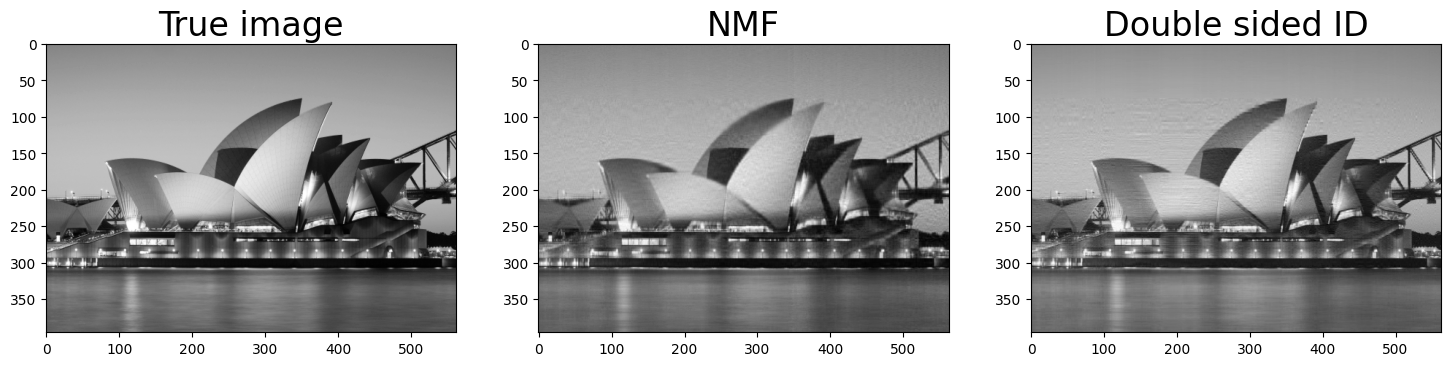

In [21]:
#
# Specify one of the target images here
#
erank = erank_Sydney
M     = M_Sydney[:]
JID   = JID_S[:]
#
# NMF 
#
iteration_max = 2000
epsilon       = 0.05
t_start       = time.time()
X,Y,iteration = nmf(M,erank,epsilon,iteration_max)
print("Time spent in the non-negative matrix factorization (NMF)",time.time()-t_start)
print("Norm ratio: ",norm(M-X@Y,'fro')/norm(M,'fro'), " reached in ", iteration, "iterations") 
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(X@Y,'gray')
plt.title('NMF',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

0 0.216500792568287
25 0.20119584713605415
50 0.15312487160636942
75 0.1260019117343891
100 0.106216561777138
125 0.09329448236497072
150 0.08488921637926497
175 0.07893636543379491
200 0.07440116228215649
225 0.07077721127607838
250 0.0677890080756823
275 0.06527230678213748
300 0.06312186188665642
325 0.061263402604821174
350 0.05963923184201978
375 0.05820483316546048
400 0.05692625254396971
425 0.05577742367560254
450 0.05473852699538478
475 0.053794494822205774
500 0.052933392306190374
525 0.052145093954031094
550 0.05142080828029096
575 0.050753093149565734
600 0.05013578282924013
Time spent in the non-negative matrix factorization (NMF) 28.792322397232056
Norm ratio:  0.049994531634782076  reached in  607 iterations


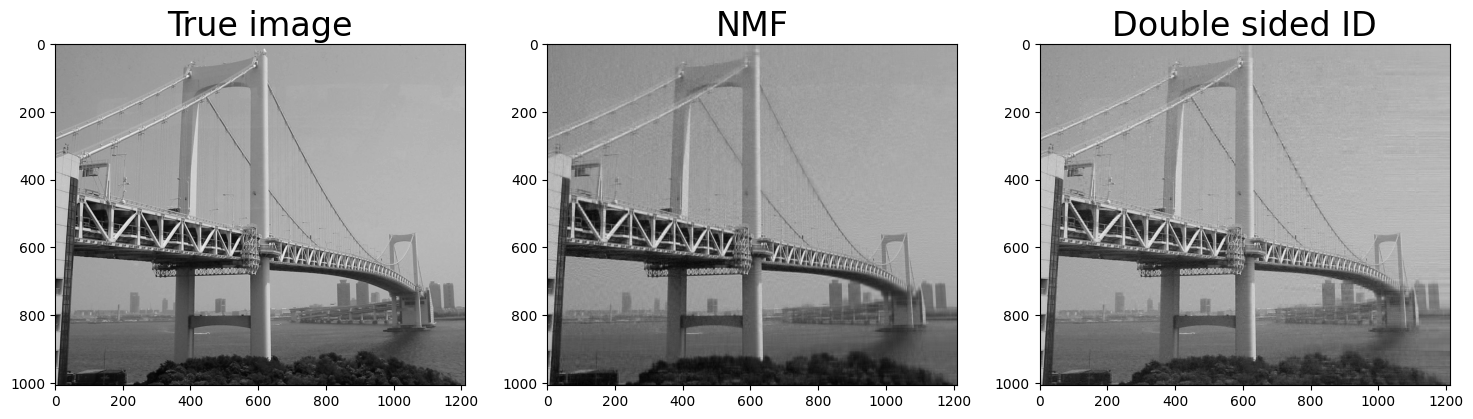

In [22]:
#
# Specify one of the target images here
#
erank = erank_Tokyo
M     = M_Tokyo[:]
JID   = JID_T[:]
#
# NMF 
#
iteration_max = 2000
epsilon       = 0.05
t_start       = time.time()
X,Y,iteration = nmf(M,erank,epsilon,iteration_max)
print("Time spent in the non-negative matrix factorization (NMF)",time.time()-t_start)
print("Norm ratio: ",norm(M-X@Y,'fro')/norm(M,'fro'), " reached in ", iteration, "iterations") 
#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(X@Y,'gray')
plt.title('NMF',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

### Questions:

* D.1 Pour $\epsilon=0.05$, indiquer pour chacune des images le temps de restitution et le nombre d'itérations. Commenter la vitesse de convergence de la méthode et la qualité de l'image reconstruite.

**Réponse**:
Hamburg: le temps de restitution est 85.46 s(NMF) avec 2740 iterations $\newline$
Sidney: le temps de restitution est 3.25 s(NMF) avec 370 iterations $\newline$
Tokyo:  le temps de restitution est 29.78 s(NMF) avec 607 iterations$\newline$

On constate que la convergence de NMF est lente par rapport à l'algorithme du double sided Id,par contre la qualité de restitution est très bonne que Double Sided ID

* D.2 A chaque fois, nous avons considéré une image exacte dans chacun des algorithmes pour en déduire une approximation de rang faible. Comment obtenir une approximation de rang faible si l'on dispose uniquement d'une image de qualité médiocre comme image initiale ? Proposez un algorithme. 

**Réponse**:
On pourra appliquer la SVD sur l'image traitée afin d'obtenir une approximation de rang faible

* Bonus Quel(s) algorithme(s) utiliseriez-vous pour approcher (au sens de l'approximation de rang faible) non pas une image mais une séquence d'images (donnée par exemple au sein d'une video) ? 


**Réponse**:
Je trouve que l'algorithme de CUR-ID est convenable car il fournit une approximation de rang faible avec un control précis de la marge de l'erreur.En plus,Le calcul parallèl va surmonter le probleme de la complexité temporelle.$\newline$
D'autre part,l'algorithme de Tucker est bien utilisé pour traiter les séquences d'image en employant des decompositions tensorielles.

### Références  (articles et exposés)

## Articles

* D. Lee and S. Cheung. <a href="https://proceedings.neurips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf">Algorithms for Non-negative Matrix Factorization </a>. Advances in Neural Information Processing Systems 13 (NIPS 2000). 


* P.-G.  Martinsson.  <a href="https://arxiv.org/pdf/1607.01649.pdf">Randomized  methods  for  matrix  computations</a>.  In  M.W.  Mahoney,  J.C.  Duchi,  and  A.C.  Gilbert, editors, The Mathematics of Data, volume 25, chapter 4, pages 187 – 231. American Mathematical Society, IAS/ParkCity Mathematics Series, 2018.


* P.-G.  Martinsson and J. Tropp.  <a href="https://arxiv.org/pdf/2002.01387.pdf">Randomized Numerical Linear Algebra: Foundations & Algorithms</a>. Acta Numerica, 29, pp 403-572, 2020.


* S. Voronin, P.-G.  Martinsson and  <a href="https://users.oden.utexas.edu/~pgm/Pubs/2017_voronin_CUR.pdf">Efficient Algorithms for CUR and Interpolative Matrix Decompositions</a>. Advances in Computational Mathematics, Volume 43, Issue 3, pp 495–516, 2017.

## Exposés

* P.-G.  Martinsson. <a href="https://simons.berkeley.edu/talks/randomized-algorithms-computing-full-matrix-factorizations">Randomized Algorithms for Computing Full Matrix Factorizations</a>, talk given at  
Randomized Numerical Linear Algebra and Applications, September 2018, Simons Institute, Berkeley, 2018.


* P.-G.  Martinsson. <a href="https://www.youtube.com/watch?v=l262Qij6flM">Randomized algorithms for pivoting and for computing interpolatory and CUR factorizations</a>, talk given at E-Numerical Linear Algebra seminars, March 2021.
